In [1]:
# %pip install aiohttp
# %pip install mysql-connector-python
# %pip install nest_asyncio
# %pip install lenskit --upgrade
# %pip install psycopg2

In [2]:
import asyncio
import aiohttp
import json
import sqlite3
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String
import urllib
from pandas.io import sql
from datetime import datetime
import numpy as np
import requests
from time import perf_counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import pickle
import nest_asyncio
nest_asyncio.apply()

# Performance Testing

In [3]:
class ConfigReader:
    def get_value(self, key):
        with open('config.json') as json_data_file:
            data = json.load(json_data_file)
        return data[key]

In [4]:
class DbManager:
    def __init__(self):
        reader = ConfigReader()
        db_connection = reader.get_value("db_connection")        
        self.conn_string = '{db_engine}{connector}://{user}:{password}@{server}/{database}?port={port}'.format(
            db_engine=db_connection['db_engine'],
            connector=db_connection['connector'],
            user=db_connection['user'],
            password=db_connection['password'],
            server=db_connection['server'],
            database=db_connection['database'],
            port=db_connection['port'])

    def get_users(self):
        # postgres:
#        return sql.read_sql("SELECT distinct \"user\" FROM rating;", create_engine(self.conn_string))
        # mysql:
        return sql.read_sql("SELECT distinct user FROM rating;", create_engine(self.conn_string))

## Test prediction and recommendation endpoints

### Prediction and recommendations methods with semaphore

In [5]:
throughputs = []

def print_stats(times, time_taken_all, num_requests):
    print(f'Total response time: {round(time_taken_all, 3)}')
    print(f'Throughput (requests per second): {round(num_requests / time_taken_all, 3)}')
    print(f'Peak response time: {round(max(times), 3)}')
    print(f'Mean response time: {round(np.mean(times), 3)}')
    print(f'99 percentile: {round(np.quantile(times, 0.99), 3)}')

def print_stats_from_file(file_name):
    obj = pickle.load(open(file_name, "rb"))  
    times = obj['times']
    time_taken_all = obj['time_taken_all']
    num_requests = obj['num_requests']
    print(f'Number of requests: {num_requests}')    
    print(f'Total response time: {round(time_taken_all, 3)}')
    print(f'Throughput (requests per second): {round(num_requests / time_taken_all, 3)}')
    print(f'Peak response time: {round(max(times), 3)}')
    print(f'Mean response time: {round(np.mean(times), 3)}')
    print(f'99 percentile: {round(np.quantile(times, 0.99), 3)}')    
    
def plot_numbers(file_name):
    #resp_time_per_request = np.genfromtxt(file_name, delimiter=',')
    obj = pickle.load(open(file_name, "rb"))
    resp_time_per_request = obj['times']
    plt.plot(resp_time_per_request)
    plt.show()
    
def hist_numbers(file_name):
#    resp_time_per_request = np.genfromtxt(file_name, delimiter=',')
    obj = pickle.load(open(file_name, "rb"))    
    resp_time_per_request = obj['times']
    plt.hist(resp_time_per_request, bins='auto')
    plt.show()

# Predictions    
async def get_preds_sem(num_sem, algo_pred, file_name=None, add_throughput=False):
    times = []
    sem = asyncio.Semaphore(num_sem)
    tasks = []    
    num_requests = len(n_rand_users)
    print(f'Number of requests: {num_requests}')
    start_preds = perf_counter()

    async with aiohttp.ClientSession() as session:
        for idx, row in n_rand_users.iterrows():
            task = asyncio.ensure_future(get_user_preds_with_sem(row['user'], algo_pred, items, session, sem, times))
            tasks.append(task)         

        responses = await asyncio.gather(*tasks)
        time_taken_all = perf_counter() - start_preds
        print_stats(times, time_taken_all, num_requests)
        
        if file_name != None and file_name != '':
            if os.path.exists(file_name):
                os.remove(file_name)
            obj = {'times': times, 'time_taken_all': time_taken_all, 'num_requests': num_requests}
            pickle.dump(obj, open(file_name, "wb"))
#            np.savetxt(file_name, times, delimiter=',')
        
        if add_throughput:
            throughputs.append(num_requests / time_taken_all)

async def get_user_preds_with_sem(user, algo, items, session, sem, times):
    async with sem:  # semaphore limits num of simultaneous downloads
        return await get_user_preds_sem(user, algo, items, session, times)        
        
async def get_user_preds_sem(user, algo, items, session, times):
    url = f'{base_url}/algorithms/{algo}/predictions?user_id={user}&items={items}'
    start = perf_counter()
    async with session.get(url) as resp:
        data = await resp.json()    
        time_taken = perf_counter() - start
        times.append(time_taken)
        
# Recommendations
async def get_recs_sem(num_sem, algo_rec, file_name=None, add_throughput=False):
    times = []
    sem = asyncio.Semaphore(num_sem)
    tasks = []
    num_requests = len(n_rand_users)
    print(f'Number of requests: {num_requests}')
    start_preds = perf_counter()

    async with aiohttp.ClientSession() as session:
        for idx, row in n_rand_users.iterrows():
            task = asyncio.ensure_future(get_user_recs_with_sem(row['user'], algo_rec, n_recs, session, sem, times))
            tasks.append(task)         

        responses = await asyncio.gather(*tasks)
        time_taken_all = perf_counter() - start_preds
        print_stats(times, time_taken_all, num_requests)
        
        if file_name != None and file_name != '':
            if os.path.exists(file_name):
                os.remove(file_name)
#            np.savetxt(file_name, times, delimiter=',')
            obj = {'times': times, 'time_taken_all': time_taken_all, 'num_requests': num_requests}
            pickle.dump(obj, open(file_name, "wb"))
        
        if add_throughput:
            throughputs.append(num_requests / time_taken_all)

async def get_user_recs_with_sem(user, algo, n_recs, session, sem, times):
    async with sem:  # semaphore limits num of simultaneous downloads
        return await get_user_preds_sem(user, algo, n_recs, session, times)        
        
async def get_user_recs_sem(user, algo, n_recs, session, times):
    url = f'{base_url}/algorithms/{algo}/recommendations?user_id={user}&num_recs={n_recs}'
    start = perf_counter()
    async with session.get(url) as resp:
        data = await resp.json()    
        time_taken = perf_counter() - start
        times.append(time_taken)   

### Gunicorn methods

In [6]:
import subprocess
import os

def get_gunicorn_master_pid():
    proc1 = subprocess.Popen(['ps', 'ax'], stdout=subprocess.PIPE)
    proc2 = subprocess.Popen(['grep', 'gunicorn'], stdin=proc1.stdout,
                             stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    proc1.stdout.close() # Allow proc1 to receive a SIGPIPE if proc2 exits.
    out, err = proc2.communicate()
    process_length = ConfigReader().get_value('process_length')
    master_id = out[:process_length].decode('utf-8').replace(' ', '')
    return master_id

def add_workers(n):
    master_id = get_gunicorn_master_pid()
    for i in range(n):
        os.system(f"sudo kill -s TTIN {master_id}")
        
def remove_workers(n):
    master_id = get_gunicorn_master_pid()
    for i in range(n):
        os.system(f"sudo kill -s TTOU {master_id}")    

### Get random users

In [7]:
reader = ConfigReader()
n_rand_users = num_requests = reader.get_value("num_requests")
dbManager = DbManager()
db_users = dbManager.get_users()
n_rand_users = db_users.sample(n=n_rand_users)

### Get config values

In [8]:
base_url = reader.get_value("rec_server_baese_url")
n_recs = reader.get_value("n_recs")
items = reader.get_value("items")
pred_algos = reader.get_value("pred_algos")
rec_algos = reader.get_value("rec_algos")

### Warm up phase

In [9]:
async def warm_up_async(current_algo=None, num_workers=24, display_logs=True):
    warm_up_user = 1
    times = []
    tasks = []
    async with aiohttp.ClientSession() as session:
        for algo in pred_algos:
            if current_algo is None or algo == current_algo:
                for w in range(num_workers * 2):
                    if display_logs:
                        print(f'Calling {algo}. Worker number: {w + 1}')
                    task = asyncio.ensure_future(get_user_preds_sem(warm_up_user, algo, items, session, times))
                    tasks.append(task)
        responses = await asyncio.gather(*tasks)

In [10]:
def warm_up(current_algo=None, num_workers=24, display_logs=True):
    loop = asyncio.get_event_loop()
    future = asyncio.ensure_future(warm_up_async(current_algo, num_workers, display_logs))
    loop.run_until_complete(future)

In [11]:
warm_up(None, 4)

Calling bias. Worker number: 1
Calling bias. Worker number: 2
Calling bias. Worker number: 3
Calling bias. Worker number: 4
Calling bias. Worker number: 5
Calling bias. Worker number: 6
Calling bias. Worker number: 7
Calling bias. Worker number: 8
Calling itemitem. Worker number: 1
Calling itemitem. Worker number: 2
Calling itemitem. Worker number: 3
Calling itemitem. Worker number: 4
Calling itemitem. Worker number: 5
Calling itemitem. Worker number: 6
Calling itemitem. Worker number: 7
Calling itemitem. Worker number: 8
Calling useruser. Worker number: 1
Calling useruser. Worker number: 2
Calling useruser. Worker number: 3
Calling useruser. Worker number: 4
Calling useruser. Worker number: 5
Calling useruser. Worker number: 6
Calling useruser. Worker number: 7
Calling useruser. Worker number: 8
Calling biasedmf. Worker number: 1
Calling biasedmf. Worker number: 2
Calling biasedmf. Worker number: 3
Calling biasedmf. Worker number: 4
Calling biasedmf. Worker number: 5
Calling biasedmf.

### Call predict and recommend endpoints from server for canonical config

#### Predictions for different algorithms

In [12]:
for algo in pred_algos:
    file_name = f'preds_{algo}_workers_4_num_req_{num_requests}.pickle'
    loop = asyncio.get_event_loop()
    print(f'Algorithm: {algo}')
    future = asyncio.ensure_future(get_preds_sem(8, algo, file_name, True))
    loop.run_until_complete(future)
    print('---------------------')
    print('')

Algorithm: bias
Number of requests: 100
Total response time: 5.015
Throughput (requests per second): 19.94
Peak response time: 0.955
Mean response time: 0.389
99 percentile: 0.927
---------------------

Algorithm: itemitem
Number of requests: 100
Total response time: 6.541
Throughput (requests per second): 15.288
Peak response time: 1.148
Mean response time: 0.504
99 percentile: 1.103
---------------------

Algorithm: useruser
Number of requests: 100
Total response time: 5.086
Throughput (requests per second): 19.662
Peak response time: 0.509
Mean response time: 0.39
99 percentile: 0.503
---------------------

Algorithm: biasedmf
Number of requests: 100
Total response time: 5.856
Throughput (requests per second): 17.077
Peak response time: 0.508
Mean response time: 0.453
99 percentile: 0.503
---------------------

Algorithm: implicitmf
Number of requests: 100
Total response time: 5.91
Throughput (requests per second): 16.92
Peak response time: 0.525
Mean response time: 0.455
99 percent

#### Recommendations

In [13]:
algo_rec = 'popular'
print(f'Algorithm: {algo_rec}')
file_name = f'recs_{algo_rec}_workers_4_num_req_{num_requests}.pickle'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_recs_sem(8, algo_rec, file_name))
loop.run_until_complete(future)
print('---------------------')
print('')
#plot_numbers(file_name)
#hist_numbers(file_name)

Algorithm: popular
Number of requests: 100
Total response time: 0.214
Throughput (requests per second): 466.49
Peak response time: 0.025
Mean response time: 0.014
99 percentile: 0.021
---------------------



### Lenskit

In [14]:
import sys
import math
from binpickle import BinPickleFile
from pathlib import Path

directory_path = 'models'

def exists_model_file(algo):
    full_file_name = Path(directory_path) / algo
    if full_file_name.exists():
        return True
    else:
        return False

def load_for_shared_mem(file_name):
    full_file_name = Path(directory_path) / file_name

    binpickle_file = BinPickleFile(full_file_name, direct=True)
    model = binpickle_file.load()
    return model

def get_predictions_from_model(model, user, items):
    try:
        results = []
        df_preds = model.predict_for_user(user, items)
        for index, value in df_preds.iteritems():
            if not math.isnan(value):
                results.append({'item': index, 'score': value})
        return results
    except:
        print(f"Unexpected preds error for user: {user}, with items: {items}. Error: {sys.exc_info()[0]}")
        raise
        

# Predictions    
async def get_preds_threads_lkpy(num_sem, model, file_name=None, add_throughput=False):
    times = []
    sem = asyncio.Semaphore(num_sem)
    tasks = []    
    num_requests = len(n_rand_users)
    print(f'Number of requests: {num_requests}')
    start_preds = perf_counter()

    async with aiohttp.ClientSession() as session:
        for idx, row in n_rand_users.iterrows():
            task = asyncio.ensure_future(get_user_preds_with_threads_lkpy(row['user'], items, session, sem, times, model))
            tasks.append(task)         

        responses = await asyncio.gather(*tasks)
        time_taken_all = perf_counter() - start_preds
        print_stats(times, time_taken_all, num_requests)
        
        if file_name != None and file_name != '':
            if os.path.exists(file_name):
                os.remove(file_name)
            np.asarray(times)
            np.savetxt(file_name, times, delimiter=',')
        
        if add_throughput:
            throughputs.append(num_requests / time_taken_all)

async def get_user_preds_with_threads_lkpy(user, items, session, sem, times, model):
    async with sem:  # semaphore limits num of simultaneous downloads
        return await get_user_preds_threads_lkpy(user, items, session, times, model)        
        
async def get_user_preds_threads_lkpy(user, items, session, times, model):
    try:
        start = perf_counter()
        results = []
        df_preds = model.predict_for_user(user, list(map(int, items.split(','))))
        for index, value in df_preds.iteritems():
            if not math.isnan(value):
                results.append({'item': index, 'score': value})
                
        time_taken = perf_counter() - start
        times.append(time_taken)
        return results
    except:
        print(f"Unexpected preds error for user: {user}, with items: {items}. Error: {sys.exc_info()[0]}")
        raise        

#### Train models

In [15]:
import train_save_model
lk_recserver_algos = reader.get_value('lk_recserver_algos')
lk_recserver_algos_not_created = []
for a in lk_recserver_algos:
    if not exists_model_file(f'{a}.bpk'):
        lk_recserver_algos_not_created.append(a)
if len(lk_recserver_algos_not_created) > 0:
    train_save_model.save_models(lk_recserver_algos_not_created)

/Users/carlos/anaconda3/lib/python3.7/site-packages/fastparquet/encoding.py:222: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  Numpy8 = numba.jitclass(spec8)(NumpyIO)
/Users/carlos/anaconda3/lib/python3.7/site-packages/fastparquet/encoding.py:224: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  Numpy32 = numba.jitclass(spec32)(NumpyIO)
/Users/carlos/anaconda3/lib/python3.7/site-packages/fastparquet/datafr

In [16]:
print('Lenskit performance:')
for lk_recserver_algo in lk_recserver_algos:
    print(f'Algo: {lk_recserver_algo}')
    model = load_for_shared_mem(f'{lk_recserver_algo}.bpk')
    file_name = f'lkpy_{lk_recserver_algo}_num_req_{num_requests}.pickle'
    loop = asyncio.get_event_loop()
    future = asyncio.ensure_future(get_preds_threads_lkpy(8, model, file_name))
    loop.run_until_complete(future)
    #plot_numbers(file_name)
    #hist_numbers(file_name)
    print('------------------')    
    warm_up(lk_recserver_algo, 8, False)
    print('Recommendation server performance:')
    file_name = f'preds_{lk_recserver_algo}_against_lkpy_workers_4_num_req_{num_requests}.pickle'
    loop = asyncio.get_event_loop()
    future = asyncio.ensure_future(get_preds_sem(8, lk_recserver_algo, file_name, True))
    loop.run_until_complete(future)
    #plot_numbers(file_name)
    #hist_numbers(file_name)
    print('*******************************************************')    


Lenskit performance:
Algo: bias
Number of requests: 100
Total response time: 0.351
Throughput (requests per second): 284.551
Peak response time: 0.24
Mean response time: 0.003
99 percentile: 0.005
------------------
Recommendation server performance:
Number of requests: 100
Total response time: 4.377
Throughput (requests per second): 22.846
Peak response time: 0.402
Mean response time: 0.337
99 percentile: 0.396
*******************************************************
Algo: biasedmf
Number of requests: 100
Total response time: 0.174
Throughput (requests per second): 573.942
Peak response time: 0.005
Mean response time: 0.002
99 percentile: 0.004
------------------
Recommendation server performance:
Number of requests: 100
Total response time: 6.081
Throughput (requests per second): 16.444
Peak response time: 0.547
Mean response time: 0.468
99 percentile: 0.535
*******************************************************
Algo: itemitem
Number of requests: 100
Total response time: 0.05
Through

ValueError: Unknown regularizer: L2

### Speedup Tests

In [ ]:
throughputs = []
linear_speedup_algos = reader.get_value("linear_speedup_algos")

In [ ]:
def call_server(file_name):
    loop = asyncio.get_event_loop()
    future = asyncio.ensure_future(get_preds_sem(8, current_algo, file_name, True))
    loop.run_until_complete(future)
#    plot_numbers(file_name)
#    hist_numbers(file_name)

In [ ]:
workers_config = reader.get_value("workers_config")
inc_config = reader.get_value("inc_config")

In [ ]:
for current_algo in linear_speedup_algos:
    i = 0
    throughputs = []
    remove_workers(3) # reduce from 4 workers to 1
    for num_workers in workers_config:
        print(f'Algo: {current_algo}, Workers: {num_workers}')
        warm_up(current_algo, num_workers, display_logs=False)
        file_name = f'linear_speedup_preds_{current_algo}_workers_{num_workers}_num_req_{num_requests}.pickle'
        call_server(file_name)
        if (num_workers != workers_config[-1]):
            print(f'add {inc_config[i]} workers')
            add_workers(inc_config[i])
        i += 1
        print('------------------')
    throughput_file_name_workers = f'throughput_single_multiple_workers_algo_{current_algo}.pickle'
    np.savetxt(throughput_file_name_workers, throughputs , delimiter=',')
    remove_workers(workers_config[-1] - 4) # remove workers to get only 4 (default config)
    print('*******************************************************')
    

#### Throughput by number of workers

In [ ]:
# throughput_file_name_workers = 'throughput_single_multiple_workers.pickle'
# np.savetxt(throughput_file_name_workers, throughputs , delimiter=',')

In [ ]:
# throughputs_workers_from_file = np.genfromtxt(throughput_file_name_workers, delimiter=',')
# workers = [1, 2, 4, 8, 16]
# y_pos = np.arange(len(throughputs_workers_from_file))

# plt.bar(y_pos, throughputs_workers_from_file, align='center', alpha=0.5)
# plt.xticks(y_pos, workers)
# plt.ylabel('Throughput')
# plt.title('Throughput by workers')

# plt.show()

## Show results

### Predict and recommend endpoints from server for canonical config

#### Predictions for different algorithms

Algorithm: bias
Number of requests: 100
Total response time: 5.015
Throughput (requests per second): 19.94
Peak response time: 0.955
Mean response time: 0.389
99 percentile: 0.927


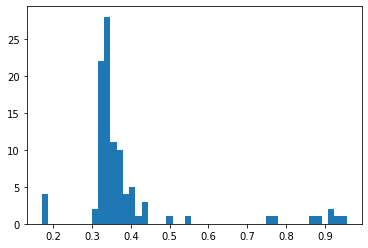

---------------------

Algorithm: itemitem
Number of requests: 100
Total response time: 6.541
Throughput (requests per second): 15.288
Peak response time: 1.148
Mean response time: 0.504
99 percentile: 1.103


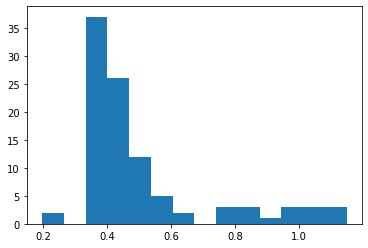

---------------------

Algorithm: useruser
Number of requests: 100
Total response time: 5.086
Throughput (requests per second): 19.662
Peak response time: 0.509
Mean response time: 0.39
99 percentile: 0.503


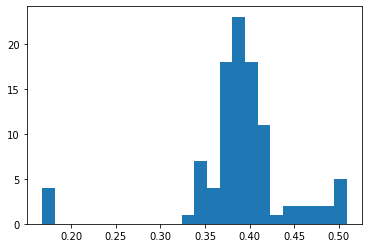

---------------------

Algorithm: biasedmf
Number of requests: 100
Total response time: 5.856
Throughput (requests per second): 17.077
Peak response time: 0.508
Mean response time: 0.453
99 percentile: 0.503


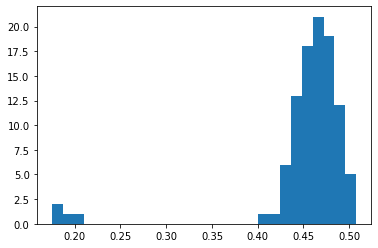

---------------------

Algorithm: implicitmf
Number of requests: 100
Total response time: 5.91
Throughput (requests per second): 16.92
Peak response time: 0.525
Mean response time: 0.455
99 percentile: 0.523


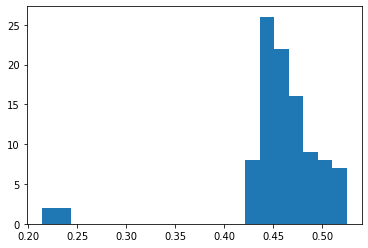

---------------------

Algorithm: funksvd
Number of requests: 100
Total response time: 4.925
Throughput (requests per second): 20.304
Peak response time: 0.459
Mean response time: 0.38
99 percentile: 0.457


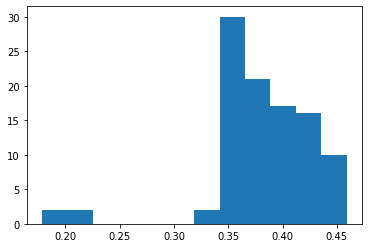

---------------------

Algorithm: tf_bpr
Number of requests: 100
Total response time: 6.731
Throughput (requests per second): 14.857
Peak response time: 0.816
Mean response time: 0.523
99 percentile: 0.709


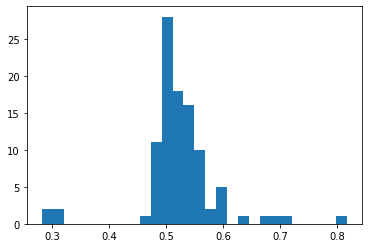

---------------------



In [17]:
# for algo in pred_algos:
#     print(f'Algorithm: {algo}')
#     file_name = f'preds_{algo}_workers_4_num_req_{num_requests}.pickle'  
#     print_stats_from_file(file_name)
#     hist_numbers(file_name)
#     print('---------------------')
#     print('')

#### Recommendations

Algorithm: popular
Number of requests: 100
Total response time: 0.214
Throughput (requests per second): 466.49
Peak response time: 0.025
Mean response time: 0.014
99 percentile: 0.021


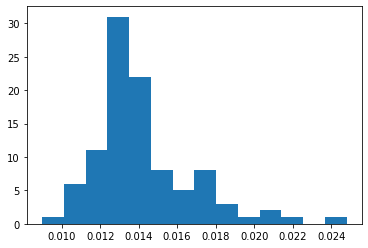

---------------------



In [18]:
# algo_rec = 'popular'
# print(f'Algorithm: {algo_rec}')
# file_name = f'recs_{algo_rec}_workers_4_num_req_{num_requests}.pickle'
# print_stats_from_file(file_name)
# hist_numbers(file_name)
# print('---------------------')
# print('')
